In [141]:
#!/usr/bin/env python

import glob
import time
import math
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2

import scipy.misc
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from skimage.feature import hog

# Import everything needed to edit/save/watch video clips
# from IPython.display import HTML
from moviepy.editor import VideoFileClip

In [142]:
class CarDetector(object):
    """Detect vehicles in images.

    Contains all the attributes and methods to perform detection
    of vehicles in an image. Includes feature extraction methods
    and training a Linear SVC classifier.

    Attributes:
        cspace: Color space in which feature extraction should be done
        spatial_size: size of the image required for feature extraction
        hist_bins: integer number of bins in the histogram
        hist_range: tupple of integer defining the range of pixel values (e.g. (0, 255))
        orient: integer defining the number of orientations in the HOG method (6 to 12)
        pix_per_cell: integer number of pixels per cell for the HOG method
        cell_per_block: integer number of cells per block for HOG method
        hog_channel: integer number of the image channel for HOG method
        vis: boolean flag indicating if the HOG method should return an image representation
        feature_vec: boolean flag indication if a feature vecture is required as output
        spatial: boolean flag indicating whether spatial feature extraction should be used
        histogram: boolean flag indicating whether histogram feature extraction should be used
        hog: boolean flag indicating whether HOG feature extraction should be used
        classifier: holds the classifier object
        scaler: holds the scaler object
    """

    def __init__(self, cspace='HSV', spatial_size=(32, 32),
                 hist_bins=32, hist_range=(0, 256), orient=9,
                 pix_per_cell=8, cell_per_block=2, hog_channel=2,
                 spatial=True, histogram=True, hog_method=True):
        '''Initializes the object with given params'''
        self.cspace = cspace
        self.spatial_size = spatial_size
        self.hist_bins = hist_bins
        self.hist_range = hist_range
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.hog_channel = hog_channel
        self.vis = False
        self.feature_vec = True
        self.spatial = spatial
        self.histogram = histogram
        self.hog = hog_method
        self.classifier = []
        self.scaler = []

    def get_classifier(self):
        '''returns the classifier'''
        return self.classifier

    def get_scaler(self):
        '''returns the scaler'''
        return self.scaler

    def train_classifier(self, cars, notcars):
        '''trains the classifier given the positive (cars) and negative (notcars) datasets'''
        classifier_file = 'classifier.pkl'
        scaler_file = 'scaler.pkl'
        # extract features from dataset
        car_features = car_detector.extract_features(cars)
        print("Car features extracted")
        notcar_features = car_detector.extract_features(notcars)
        print("Other features extracted")# Create an array stack of feature vectors
        x_data = np.vstack((car_features, notcar_features)).astype(np.float64)
        # Fit a per-column scaler
        x_scaler = StandardScaler().fit(x_data)
        print("X_scaler ready")
        #save the model
        joblib.dump(x_scaler, scaler_file)
        # Apply the scaler to X - normalise data
        scaled_x = x_scaler.transform(x_data)
        print("Data normalised")
        # Define the labels vector
        y_data = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        x_train, x_test, y_train, y_test = train_test_split(scaled_x, y_data, test_size=0.2,
                                                            random_state=rand_state)

        # Use a linear SVC
        svc = LinearSVC()
        # Check the training time for the SVC
        tstamp1 = time.time()
        svc.fit(x_train, y_train)
        tstamp2 = time.time()
        print(tstamp2-tstamp1, 'Seconds to train SVC...')
        # Check the score of the SVC
        print('Train Accuracy of SVC = ', svc.score(x_train, y_train))
        print('Test Accuracy of SVC = ', svc.score(x_test, y_test))
        # Check the prediction time for a single sample
        tstamp1 = time.time()
        prediction = svc.predict(x_test[0].reshape(1, -1))
        print("prediction", prediction)
        tstamp2 = time.time()
        print(tstamp2-tstamp1, 'Seconds to predict with SVC')
        print(svc)
        # save the model
        joblib.dump(svc, classifier_file)
        self.classifier = svc
        self.scaler = x_scaler
        print("Model saved as:", classifier_file, " and ", scaler_file)

    def load_classifier(self, classifier_file, scaler_file):
        '''loads the classifier and scaler from files'''
        self.classifier = joblib.load(classifier_file)
        self.scaler = joblib.load(scaler_file)
        print("Model loaded: \n\n", self.classifier)

    def bin_spatial(self, img):
        '''computes binned color features'''
        # Use cv2.resize().ravel() to create the feature vector
        features = cv2.resize(img, self.spatial_size).ravel()
        # Return the feature vector
        return features

    def color_hist(self, img):
        '''computes color histogram features'''
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(img[:, :, 0], bins=self.hist_bins, range=self.hist_range)
        channel2_hist = np.histogram(img[:, :, 1], bins=self.hist_bins, range=self.hist_range)
        channel3_hist = np.histogram(img[:, :, 2], bins=self.hist_bins, range=self.hist_range)
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        # Return the individual histograms, bin_centers and feature vector
        return hist_features

    def get_hog_features(self, img_channel):
        '''extracts hog features from the given image channel'''
        # Call with two outputs if vis==True
        if self.vis:
            features, hog_image = hog(img_channel, orientations=self.orient,
                                      pixels_per_cell=(self.pix_per_cell, self.pix_per_cell),
                                      cells_per_block=(self.cell_per_block, self.cell_per_block),
                                      transform_sqrt=True, visualise=self.vis,
                                      feature_vector=self.feature_vec)
            return features, hog_image
        # Otherwise call with one output
        else:
            features = hog(img_channel, orientations=self.orient,
                           pixels_per_cell=(self.pix_per_cell, self.pix_per_cell),
                           cells_per_block=(self.cell_per_block, self.cell_per_block),
                           transform_sqrt=True, visualise=self.vis, feature_vector=self.feature_vec)
            return features

    def extract_features_img(self, rgb_image):
        '''extracts features from the given rgb image'''
        # apply color conversion if other than 'RGB'
        features = []
        if self.cspace != 'RGB':
            if self.cspace == 'HSV':
                feature_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)
            elif self.cspace == 'LUV':
                feature_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2LUV)
            elif self.cspace == 'HLS':
                feature_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HLS)
            elif self.cspace == 'YUV':
                feature_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2YUV)
            elif self.cspace == 'YCrCb':
                feature_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(rgb_image)
        # Apply bin_spatial() to get spatial color features
        if self.spatial:
#             features.append(self.bin_spatial(rgb_image)) # extract spatial only in RGB
            features.append(self.bin_spatial(feature_image))
        # Apply color_hist() also with a color space option now
        if self.histogram:
            features.append(self.color_hist(feature_image))
        if self.hog:
            if self.hog_channel == 'ALL':
                features.append(self.get_hog_features(feature_image[:, :, 0]))
                features.append(self.get_hog_features(feature_image[:, :, 1]))
                features.append(self.get_hog_features(feature_image[:, :, 2]))
            else:
                features.append(self.get_hog_features(feature_image[:, :, self.hog_channel]))
        features = np.concatenate((features))
        return features

    # Define a function to extract features from a list of images
    # Have this function call bin_spatial() and color_hist()
    # this function combines color, histogram and hog features extraction
    def extract_features(self, img_files):
        '''extracts features from all the images in the given list of files (img_files)'''
        # Create a list to append feature vectors to
        features = []
        # Iterate through the list of images
        for afile in img_files:
            # Read in each one by one
#             rgb_image = mpimg.imread(afile)
            rgb_image = scipy.misc.imread(afile)
#             image = cv2.imread(afile) # reads a file into bgr values 0-255
            features.append(self.extract_features_img(rgb_image))

        # Return list of feature vectors
        return features

In [143]:
def load_dataset():
    '''load data from the dataset'''
    cars = []
    notcars = []

    # load vehicle images
    images = glob.iglob('vehicles/*/*.png', recursive=True)
    for image in images:
        cars.append(image)

    # load non vehicle images
    images = glob.iglob('non-vehicles/*/*.png', recursive=True)
    for image in images:
        notcars.append(image)

    print('cars = ', len(cars))
    print('notcars = ', len(notcars))
    return cars, notcars

def peak_data(cars, notcars):
    '''plot one random example of each from the dataset'''
    data_info = data_look(cars, notcars)
    print('Your function returned a count of',
          data_info["n_cars"], ' cars and',
          data_info["n_notcars"], ' non-cars')
    print('of size: ', data_info["image_shape"], ' and data type:',
          data_info["data_type"])
    # choose random car / not-car indices and plot example images
    car_ind = np.random.randint(0, len(cars))
    notcar_ind = np.random.randint(0, len(notcars))

    # Read in car / not-car images
    car_image = mpimg.imread(cars[car_ind])
    notcar_image = mpimg.imread(notcars[notcar_ind])

    # Plot the examples
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(car_image)
    plt.title('Example Car Image')
    plt.subplot(122)
    plt.imshow(notcar_image)
    plt.title('Example Not-car Image')
    plt.show()

def data_look(car_list, notcar_list):
    '''return some characteristics of the dataset'''
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

# Sliding Window Implementation

In [146]:

# Define a function that takes an image,
# start and stop positions in both x and y,
# window size (x and y dimensions),
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5), max_y=780):
    '''returns a list of rectangles of a specific size spanning the image at relevant locations'''
    height, width, channels = img.shape
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] is None:
        x_start_stop[0] = 0
    if x_start_stop[1] is None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] is None:
        y_start_stop[0] = 0
    if y_start_stop[1] is None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = int(xs*nx_pix_per_step + x_start_stop[0])
            endx = int(startx + xy_window[0])
            starty = int(ys*ny_pix_per_step + y_start_stop[0])
            endy = int(starty + xy_window[1])
            # Append window position to list
            if endy < height and endx < width and endy < max_y:
                window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# create a list of rectangles with different sizes across the
# lower part of the image for searching cars
def create_list_rectangles(img):
    '''creates a list of rectangles of different sizes across relevant section of the image'''
    height, width, channels = img.shape
    window_list = ()
    rectangles = []

    step_h = 32
    start_h = step_h#int(height/4)
    stop_h = height
#     size_of_sq = int(256 * (1/height))
    y_val = int(9*height/16)

    size_vec = [100, 140]
    overlap_vec = [0.5, 0.5]

    for i, _ in enumerate(size_vec):
        size = size_vec[i]
        overlap = overlap_vec[i]
        window_list = slide_window(img, x_start_stop=[0, width+size],
                                   y_start_stop=[y_val, y_val+4*size],
                                   xy_window=(size, size),
                                   xy_overlap=(overlap, overlap),
                                   max_y=height*0.9)
        rectangles.extend(window_list)
    return rectangles

In [130]:
def draw_rectangles(img, window_list, color=(255, 255, 255)):
    '''draw the list of rectangles in the image'''
    labeled_img = img.copy()
    for window in window_list:
        pt1 = window[0]
        pt2 = window[1]
        thickness = 4
        cv2.rectangle(labeled_img, pt1, pt2, color, thickness)
    return labeled_img

In [131]:
def get_heat_map(img, rectangles, car_detector_obj, heat_increment=25, debug=0):
    '''creates a heat map'''
    cv_filled = -1
    heat_map = np.zeros_like(img)
    if debug:
        positive_cars = np.copy(img)
    for rectangle in rectangles:
        heat_img = np.zeros_like(img)
        pt1 = rectangle[0]
        pt2 = rectangle[1]
        crop_img = img[pt1[1]:pt2[1], pt1[0]:pt2[0]]
        size = (64, 64)
        crop_img = cv2.resize(crop_img, size)#.astype(np.float64)

        img_features = car_detector_obj.extract_features_img(crop_img)

        features = np.vstack((img_features)).astype(np.float64)
        features = np.array(features).reshape(1, -1)

        feature_scaler = car_detector_obj.get_scaler()
        classifier = car_detector_obj.get_classifier()

        scaled_features = feature_scaler.transform(features)
        prediction = classifier.predict(scaled_features.reshape(1, -1))

        if prediction == 1:
            if debug:
                cv2.rectangle(positive_cars, pt1, pt2, color=(255, 255, 255), thickness=4)

            cv2.rectangle(heat_img, pt1, pt2,
                          color=(heat_increment, heat_increment, heat_increment),
                          thickness=cv_filled)
            heat_map = cv2.add(heat_map, heat_img)
    if debug:
        plt.imshow(positive_cars)
        plt.show()
    return heat_map

In [132]:
# apply filter to the heat_map
# Note: th_ratio should be a ratio (0-1)
# It will be used with respect to the maximum pixel value in the image
def filter_heat_map(heat_map, th_ratio=0.5):
    '''filter the heat map given the threshold (th_ratio)'''
    red_channel = np.copy(heat_map[:, :, 0])
    threshold = np.amax(red_channel)*th_ratio # define threshold
    filt_heat_map = np.zeros_like(heat_map)
    if np.amax(red_channel) > 0:
        red_channel[red_channel >= threshold] = 255
        red_channel[red_channel < threshold] = 0
        filt_heat_map[:, :, 0] = red_channel
    return filt_heat_map

In [133]:
def get_detected(heat_map, area_th=20, heat_th=80):
    '''computes positions and bounding rectangles identifying the location of detected vehicles'''
     # define a threshold for minimum area required to be a positive detection
    imgray = heat_map[:, :, 0]#cv2.cvtColor(heat_map,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray.astype(np.uint8), heat_th, 255, cv2.THRESH_BINARY) #60

    im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    data = []
    for contour in contours:
        area = cv2.contourArea(contour)

        if area > area_th:
            x_pos, y_pos, width, height = cv2.boundingRect(contour)
            M = cv2.moments(contour)
            # calculate image centroid
            centroid_x = int(M['m10']/M['m00'])
            centroid_y = int(M['m01']/M['m00'])
            pt1 = (x_pos, y_pos)
            pt2 = (x_pos+width, y_pos+height)
            coord = [centroid_x, centroid_y]
            rect = [pt1, pt2]
            data.append((coord, rect, area))
    return data

In [134]:
def get_distance(pt1, pt2):
    '''computes the euclidean distance between two points'''
    return math.sqrt((pt1[0]-pt2[0])**2+(pt1[1]-pt2[1])**2)

In [135]:
def filter_by_location(data, valid_data, threshold=50):
    '''filters valid data based on the threshold distance'''
#     for each element of data, chech if there is one in filter data that is close enough
#     if so, then it is a valid element
    posit_data = []
    for elem in data:
        for valid_el in valid_data:
            #compute distance
            distance = get_distance(elem[0], valid_el[0])
            if distance < threshold:
                posit_data.append(elem)
    return posit_data

In [136]:
def create_map_from_data(img, posit_data, heat_increment=25):
    '''convert the data (as rectangles) in a heat map'''
    new_heat_map = np.zeros_like(img) # 1 channel is enough
    for elem in posit_data:
        cv2.rectangle(new_heat_map, elem[1][0], elem[1][1],
                      (heat_increment, heat_increment, heat_increment),
                      thickness=-1) #filled rect
    return new_heat_map

In [137]:
def process_image(img, debug=0):
    '''pipeline to process a single image (e.g. from camera or video stream)'''
    heat_increment = 25 #25
    heat_thres = 80
    if not hasattr(process_image, "heat_map_old"):
        process_image.heat_map_old = np.zeros_like(img)

    if not process_image.heat_map_old.size:
        process_image.heat_map_old = np.zeros_like(img)

    decay = 0.05
    # apply decay to the heat_map
    process_image.heat_map_old = process_image.heat_map_old*(1-decay)

    #get heat_map
    heat_map = get_heat_map(img, process_image.rectangles,
                            process_image.car_detector, heat_increment)

    #filter the heat map to get rid of false positives
    filtered_heat_map = filter_heat_map(heat_map, th_ratio=0.5)
    valid_data = get_detected(filtered_heat_map, area_th=1000, heat_th=heat_thres)
    # now that we know the location of valid positives
    # we can use the original heat map to get the complete area and filter out false positives
    filtered_heat_map = filter_heat_map(heat_map, th_ratio=0.05)
    data = get_detected(filtered_heat_map, area_th=1000, heat_th=heat_thres)
    posit_data = filter_by_location(data, valid_data)

    # now we create a new filtered_heat_map with the posit_data only
    filtered_heat_map = create_map_from_data(img, posit_data, heat_increment=255)

    process_image.heat_map_old = (filtered_heat_map*0.2 + process_image.heat_map_old*0.8)

    final_data = get_detected(process_image.heat_map_old, area_th=1000, heat_th=100)

    detected_car_rectangles = []
    for elem in final_data:
        detected_car_rectangles.append(elem[1])

    detected_cars_img = draw_rectangles(img, detected_car_rectangles, color=(255, 255, 255))

    if debug:
        # Ploting images
        labeled_img = draw_rectangles(img, process_image.rectangles)

        fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(24, 9))
        fig.tight_layout()

        ax1.imshow(heat_map)
        ax1.set_title('Heat map')
        ax2.imshow(filtered_heat_map.astype(np.uint8))
        ax2.set_title('Filtered heat_map')
        ax3.imshow(process_image.heat_map_old.astype(np.uint8))
        ax3.set_title('Used heat_map')
        ax4.imshow(img)
        ax4.set_title('Source image')
        ax5.imshow(labeled_img)
        ax5.set_title('Sliding Window')
        ax6.imshow(detected_cars_img)
        ax6.set_title('Confirmed cars')
        ax1.axis('off')
        ax2.axis('off')
        ax3.axis('off')
        ax4.axis('off')
        ax5.axis('off')
        ax6.axis('off')
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()

    return detected_cars_img

In [156]:
def process_video(input_video_file, output_video_file, pipeline_func):
    '''process a video file'''
    video_output = output_video_file
    clip1 = VideoFileClip(input_video_file)
    video_clip = clip1.fl_image(pipeline_func) #NOTE: this function expects color images!!
    %time video_clip.write_videofile(video_output, audio=False)
    print('Finished processing video file')

# Method
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


# Train or Load existing Model
# ========================

Model loaded: 

 LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


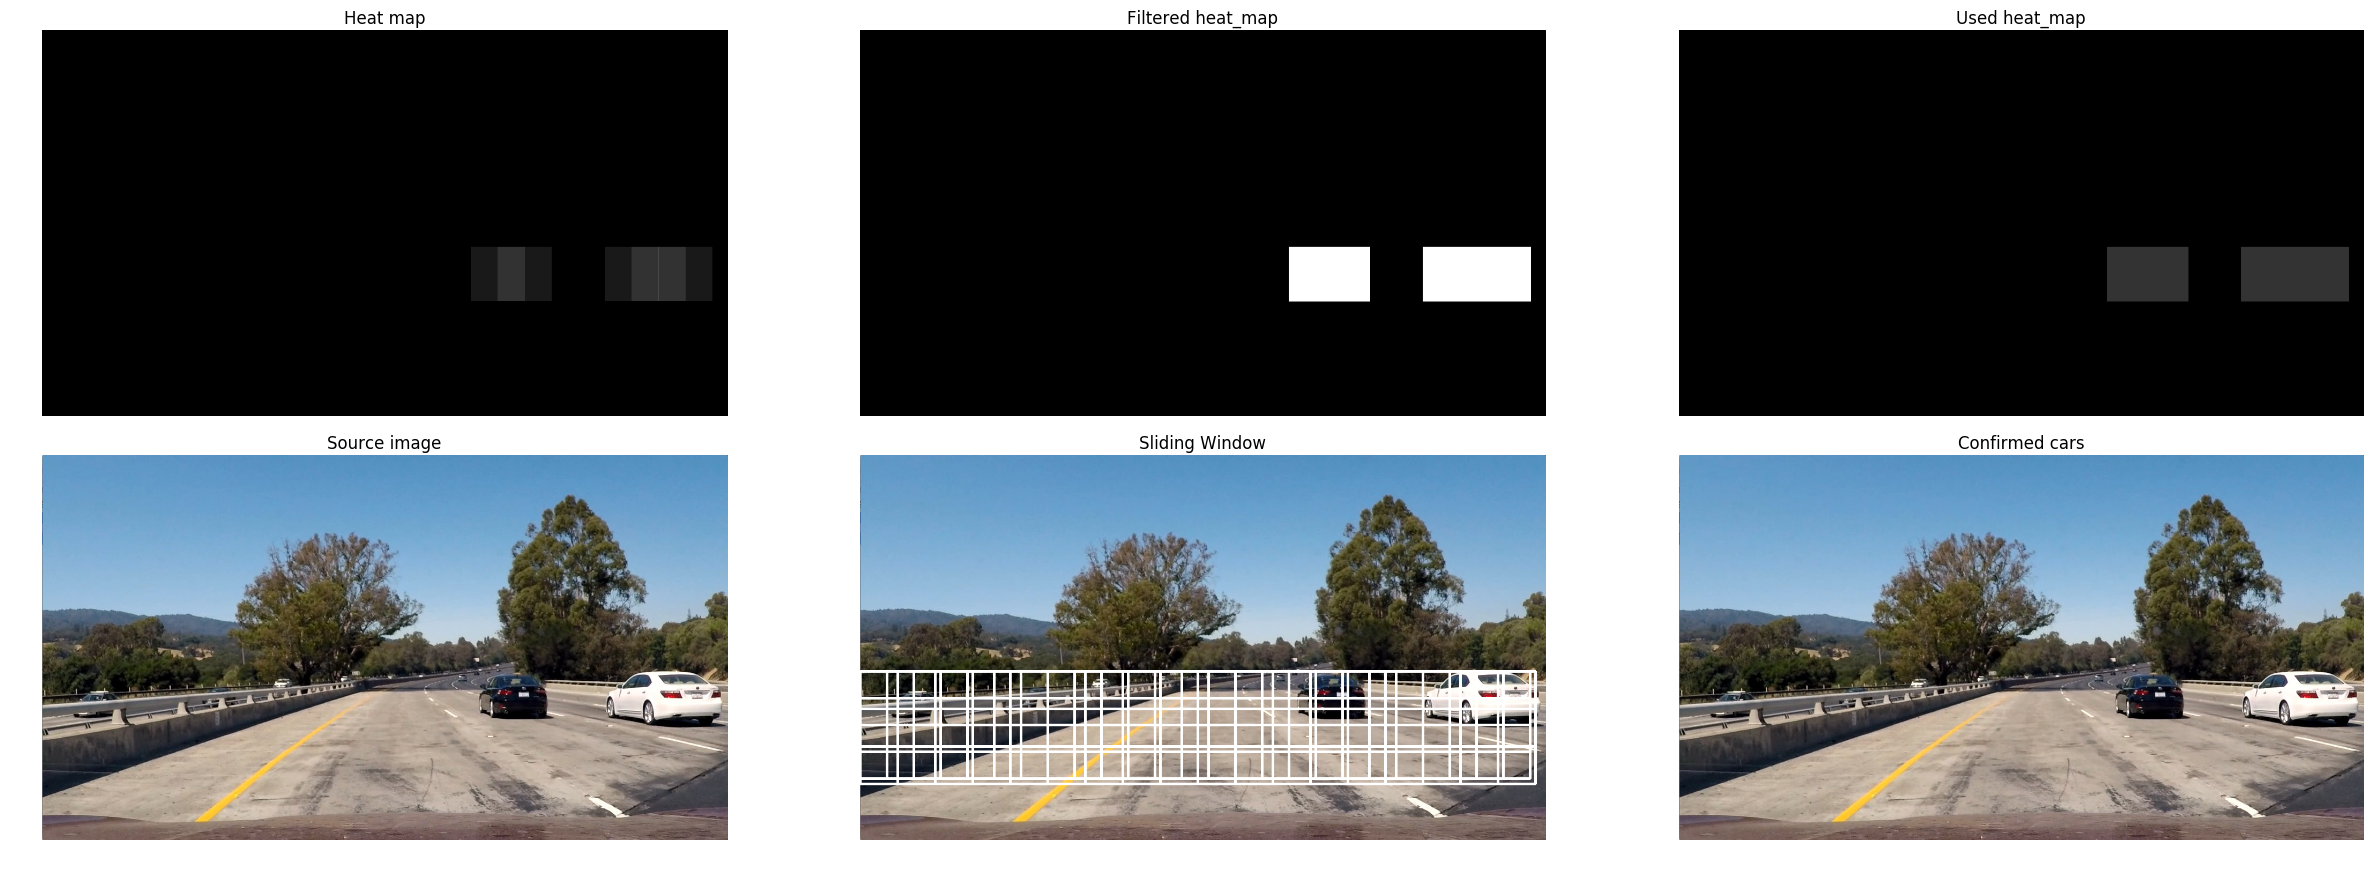

In [160]:
def main():
    # my code here
    new_model = False
#     new_model = True

    # create a CarDetector object
    # cspace='RGB', spatial_size=(16, 16),hist_bins=16,hog_channel=0) #cspace='YUV',hog_channel=1)
    # Options: RGB, HSV, LUV, HLS, YUV
    car_detector = CarDetector(cspace='HSV', hog_channel=2, spatial=True,
                               histogram=True, hog_method=True)

    if new_model:
        # load the dataset
        cars, notcars = load_dataset()
        peak_data(cars, notcars)
        #train the classifier
        car_detector.train_classifier(cars, notcars)
    else:
        # load existing model
        car_detector = CarDetector(cspace='HSV', hog_channel=2, spatial=True,
                                   histogram=True, hog_method=True)
        car_detector.load_classifier('classifier.pkl', 'scaler.pkl')

    # Test pipeline in an test image
    im_filename = 'test_images/test_01.jpg' # two cars, black and white
    rgb_image = scipy.misc.imread(im_filename)
    #reset heat_map_old
    process_image.heat_map_old = np.zeros_like(rgb_image)
    process_image.car_detector = car_detector
    process_image.rectangles = create_list_rectangles(rgb_image)
    # im_filename = 'test_images/test_14.png' # two cars, black and white
    # im_filename = 'test_images/test_13.png' # two cars, black and white
    # im_filename = 'test_images/test_12.png' # two cars, black and white
    # im_filename = 'test_images/test_11.png' # two cars, black and white
    # im_filename = 'test_images/test_10.png' # two cars, black and white
    # im_filename = 'test_images/test_09.png' # two cars, black and white
    # im_filename = 'test_images/test_08.png' # two cars, black and white
    # im_filename = 'test_images/test_07.png' # two cars, black and white
    # im_filename = 'test_images/test_06.jpg' # two cars, black and white
    # im_filename = 'test_images/test_05.jpg' # two cars, black and white
    # im_filename = 'test_images/test_04.jpg' # two cars, black and white
    # im_filename = 'test_images/test_03.jpg' # white car
    # im_filename = 'test_images/test_02.jpg' # no cars
    im_filename = 'test_images/test_01.jpg' # two cars, black and white
    result = process_image(rgb_image, debug=1)

    #process a video file
    process_image.heat_map_old = np.zeros_like(rgb_image)
    process_image.car_detector = car_detector
    process_image.rectangles = create_list_rectangles(rgb_image)
#     process_video('test_video.mp4', 'output_images/test_output.mp4', process_image)

#     process_video('small_video_2.mp4', 'output_images/small_output_2.mp4', process_image)

#     process_video('small_video_3.mp4', 'output_images/small_output_3.mp4', process_image)

#     process_video('project_video.mp4', 'output_images/project_output.mp4', process_image)    


if __name__ == "__main__":
    main()